In [12]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt


%matplotlib inline


IMAGE_SIZE_NO_CROP = 256  # Size of image before cropping
IMAGE_SIZE = 64  # Shapes of input image
BATCH_SIZE = 64  # Batch size
DATA_PATH = "/content/celeba/img_align_celeba/img_align_celeba/"
RANDOM_SEED = 27

tf.random.set_seed(RANDOM_SEED)

In [15]:
 ! pip install -q kaggle

In [16]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mudgalvaibhav","key":"5a7a57ee93cce3d15f8c2599f7786303"}'}

In [18]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
! chmod 600 ~/.kaggle/kaggle.json

In [20]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-29 13:51:53          11415  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6945  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2693  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1749  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [21]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:11<00:00, 122MB/s]
100% 1.33G/1.33G [00:11<00:00, 123MB/s]


In [22]:
!mkdir celeba

mkdir: cannot create directory ‘celeba’: File exists


In [23]:
!unzip celeba-dataset.zip -d celeba

Streaming output truncated to the last 5000 lines.
  inflating: celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
num_images = len(os.listdir(os.path.join(DATA_PATH, "")))
print(f"Num images: {num_images}")

Num images: 202599


In [25]:
celeb_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_PATH,
    label_mode=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE_NO_CROP, IMAGE_SIZE_NO_CROP),
    seed=RANDOM_SEED,
)

Found 202599 files belonging to 1 classes.


In [26]:
CACHE_FILE = "/content/gdrive/My Drive/Cache"


def process(image):
    #     images are centered on eyes, we will crop faces utilizing that fact
    height, width = image.shape[1], image.shape[2]
    print(height, width)
    offset_height = int(height * 0.35)
    offset_width = int(height * 0.27)

    image = tf.image.crop_to_bounding_box(
        image, offset_height, offset_width, int(width * 0.45), int(height * 0.45)
    )
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], preserve_aspect_ratio=True)

    image = tf.cast((image - 127.5) / 127.5, tf.float32) # Normalize the images to [-1, 1]
    print(image.shape)
    return image


celeb_dataset = (
    celeb_dataset.map(process)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    .cache(filename=CACHE_FILE)
)

256 256
(None, 64, 64, 3)


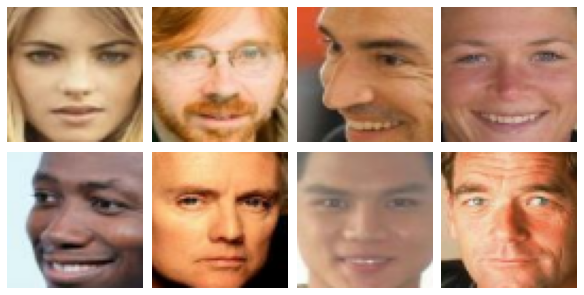

In [27]:
fig = plt.figure(figsize=(8, 4), constrained_layout=True)


for images in celeb_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow((images[i].numpy() * 127.5 + 127.5).astype("uint8"))
        plt.axis("off")

In [28]:
Z_DIM = 100  # Dimension of face's manifold
GENERATOR_DENSE_SIZE = 1024  # Length of first tensor in generator
N_CHANNELS = 3  # Number channels of input image
NUM_CONV_DISCRIMINATOR = 4  # amount of convolution layers in discriminator model

In [31]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential


def make_generator_model():
    model = Sequential()
    model.add(
        layers.Dense(
            2 * 2 * GENERATOR_DENSE_SIZE,
            use_bias=False,
            input_shape=(Z_DIM,),
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 2, GENERATOR_DENSE_SIZE)))

    assert model.output_shape == (None, 2, 2, GENERATOR_DENSE_SIZE)  #None is the batch size

    model.add(layers.Conv2DTranspose(1024, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 1024)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(
          layers.Conv2DTranspose(
              3,
              (5, 5),
              strides=(2, 2),
              padding="same",
              use_bias=False,
              activation="tanh",
          )
      )

    assert model.output_shape == (None, 64, 64, 3)

    return model


In [32]:
generator = make_generator_model()

In [33]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 1024)        26214400  
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 1024)       

In [34]:
def make_discriminator_model():
    model = Sequential()

    for i in range(NUM_CONV_DISCRIMINATOR):
        model.add(
            layers.Conv2D(
                64 * 2 ** i,
                (5, 5),
                strides=(2, 2),
                padding="same",
                input_shape=[IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            )
        )
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [35]:
discriminator = make_discriminator_model()

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [37]:
from tensorflow.keras import optimizers


generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [38]:
EPOCHS = 30
NUM_SAMPLES_TO_GENERATE = 8
NUM_CHECKPOINT = 10


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.uniform([NUM_SAMPLES_TO_GENERATE, Z_DIM])

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(
            gen_loss, generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, discriminator.trainable_variables
        )

        generator_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )
        discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )

In [40]:
from IPython.display import clear_output
import time


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)


        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [41]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 4), constrained_layout=True)

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i + 1)
        plt.imshow((predictions[i].numpy() * 127.5 + 127.5).astype("uint8"))
        plt.axis("off")

    plt.savefig("/content/gdrive/My Drive/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

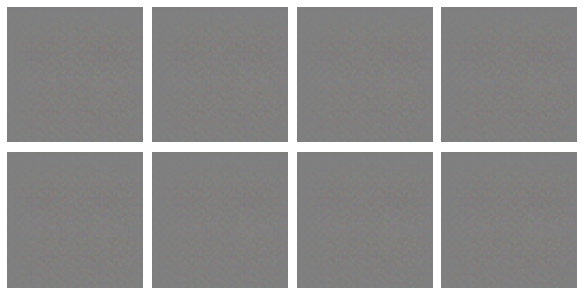

Time for epoch 1 is 612.99640417099 sec


In [ ]:
train(celeb_dataset, EPOCHS)